In [1]:
"""
LSTMを用いた多変量時系列予測

利用データ：北京PM2.5データセット
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data


https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

LSTMを用いた多変量時系列予測 by Keras
LSTM（Long Short-Term Memory）リカレントニューラルネットワーク
は、複数の入力変数を持つ問題をほぼシームレスにモデル化できる。

No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
pm2.5: PM2.5 concentration
DEWP: Dew Point
TEMP: Temperature
PRES: Pressure
cbwd: Combined wind direction
Iws: Cumulated wind speed
Is: Cumulated hours of snow
Ir: Cumulated hours of rain
"""
pass


In [2]:
URL="https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"


In [3]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Using TensorFlow backend.


In [4]:
# data loading
from pandas import read_csv
from datetime import datetime

# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv(URL,  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
print(dataset.head(50))

                     No  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
year_month_day_hour                                                   
2010-01-01 00:00:00   1    NaN   -21 -11.0  1021.0   NW   1.79   0   0
2010-01-01 01:00:00   2    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2010-01-01 02:00:00   3    NaN   -21 -11.0  1019.0   NW   6.71   0   0
2010-01-01 03:00:00   4    NaN   -21 -14.0  1019.0   NW   9.84   0   0
2010-01-01 04:00:00   5    NaN   -20 -12.0  1018.0   NW  12.97   0   0
2010-01-01 05:00:00   6    NaN   -19 -10.0  1017.0   NW  16.10   0   0
2010-01-01 06:00:00   7    NaN   -19  -9.0  1017.0   NW  19.23   0   0
2010-01-01 07:00:00   8    NaN   -19  -9.0  1017.0   NW  21.02   0   0
2010-01-01 08:00:00   9    NaN   -19  -9.0  1017.0   NW  24.15   0   0
2010-01-01 09:00:00  10    NaN   -20  -8.0  1017.0   NW  27.28   0   0
2010-01-01 10:00:00  11    NaN   -19  -7.0  1017.0   NW  31.30   0   0
2010-01-01 11:00:00  12    NaN   -18  -5.0  1017.0   NW  34.43   0   0
2010-0

In [5]:
#  Organizing columns
#      No  pm2.5       DEWP  TEMP    PRES     cbwd         Iws               Is          Ir
# ->  *   'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain'

# drop column 'No'
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# index column's name ->  date
dataset.index.name = 'date'

In [6]:
# Processing missing data
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours to fix missing data
dataset = dataset[24:]

# save to file
#dataset.to_csv('pollution.csv')

In [7]:
print(dataset)

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
2010-01-02 05:00:00      109.0   -7  -6.0  1022.0      SE     7.14     3     0
2010-01-02 06:00:00      105.0   -7  -6.0  1023.0      SE     8.93     4     0
2010-01-02 07:00:00      124.0   -7  -5.0  1024.0      SE    10.72     0     0
2010-01-02 08:00:00      120.0   -8  -6.0  1024.0      SE    12.51     0     0
2010-01-02 09:00:00      132.0   -7  -5.0  1025.0      SE    14.30     0     0
2010-01-02 10:00:00      140.0   -7  -5.0  1026.0   

In [8]:
# categorical data processing

# integer encode direction
values = dataset.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')

print(values)

[[ 129.          -16.           -4.         ...,    1.78999996    0.            0.        ]
 [ 148.          -15.           -4.         ...,    2.68000007    0.            0.        ]
 [ 159.          -11.           -5.         ...,    3.56999993    0.            0.        ]
 ..., 
 [  10.          -22.           -3.         ...,  242.69999695    0.            0.        ]
 [   8.          -22.           -4.         ...,  246.72000122    0.            0.        ]
 [  12.          -21.           -3.         ...,  249.8500061     0.            0.        ]]


In [9]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed)


       var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2       0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3       0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4       0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5       0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   
6       0.109658   0.485294   0.213115   0.563637   0.666667   0.011433   
7       0.105634   0.485294   0.213115   0.581818   0.666667   0.014492   
8       0.124748   0.485294   0.229508   0.600000   0.666667   0.017551   
9       0.120724   0.470588   0.213115   0.600000   0.666667   0.020610   
10      0.132797   0.485294   0.229508   0.618183   0.666667   0.023669   
11      0.140845   0.485294   0.229508   0.636364   0.666667   0.029018   
12      0.152918   0.470588   0.229508   0.636364   0.666667   0.034367   
13      0.148893   0.4705

In [10]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
2s - loss: 0.0584 - val_loss: 0.0558
Epoch 2/50
0s - loss: 0.0394 - val_loss: 0.0540
Epoch 3/50
0s - loss: 0.0248 - val_loss: 0.0429
Epoch 4/50
0s - loss: 0.0173 - val_loss: 0.0342
Epoch 5/50
0s - loss: 0.0155 - val_loss: 0.0216
Epoch 6/50
0s - loss: 0.0148 - val_loss: 0.0174
Epoch 7/50
0s - loss: 0.0147 - val_loss: 0.0166
Epoch 8/50
0s - loss: 0.0148 - val_loss: 0.0156
Epoch 9/50
1s - loss: 0.0147 - val_loss: 0.0154
Epoch 10/50
0s - loss: 0.0146 - val_loss: 0.0153
Epoch 11/50
0s - loss: 0.0146 - val_loss: 0.0150
Epoch 12/50
0s - loss: 0.0145 - val_loss: 0.0146
Epoch 13/50
0s - loss: 0.0146 - val_loss: 0.0148
Epoch 14/50
0s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
0s - loss: 0.0145 - val_loss: 0.0146
Epoch 16/50
0s - loss: 0.0146 - val_loss: 0.0145
Epoch 17/50
0s - loss: 0.0145 - val_loss: 0.0142
Epoch 18/50
0s - loss: 0.0146 - val_loss: 0.0144
Epoch 19/50
0s - loss: 0.0146 - val_loss: 0.0142
Epoch 20/50
0s - loss: 0.0145

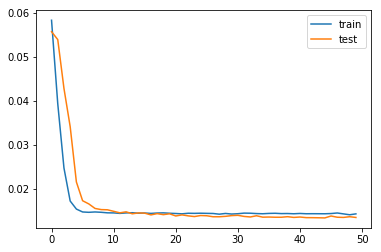

In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y,
                    epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.561


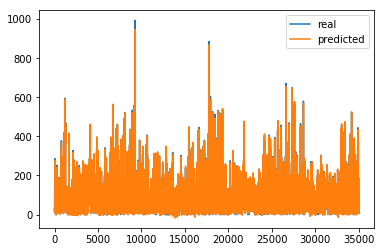

In [14]:
# plot prediction and real data
pyplot.plot(inv_y, label='real')
pyplot.plot(inv_yhat, label='predicted')
pyplot.legend()
pyplot.show()

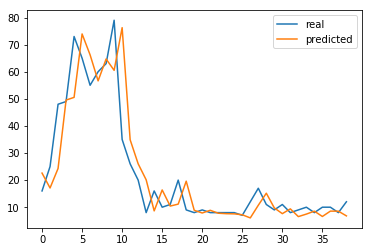

In [15]:
# plot prediction and real data
pyplot.plot(inv_y[35000:], label='real')
pyplot.plot(inv_yhat[35000:], label='predicted')
pyplot.legend()
pyplot.show()

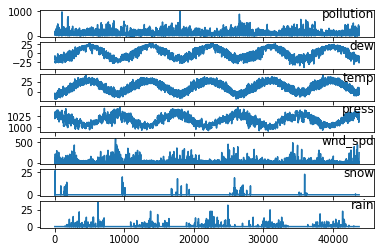

In [16]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()